In [14]:
import pandas as pd

In [15]:
import numpy as np

In [16]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

In [83]:
from sklearn.model_selection import train_test_split

In [89]:
from sklearn.linear_model import LinearRegression

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [91]:
from sklearn.metrics import r2_score

In [62]:
import hashlib

In [18]:
dataset = pd.read_csv(r"C:\Users\Saatvik\Downloads\Electric_Vehicle_Population_Data.csv")


#DATA CLEANING

In [20]:
print("Missing values by column:\n")
print(dataset.isnull().sum())

Missing values by column:

VIN (1-10)                                             0
County                                                10
City                                                  10
State                                                  0
Postal Code                                           10
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         5
Legislative District                                 649
DOL Vehicle ID                                         0
Vehicle Location                                      88
Electric Utility                                      10
2020 Census Tract                                     10
dtype: int64


#Handle zero/missing in Base MSRP and Electric Range


In [23]:
if 'Electric Range' in dataset.columns:
    dataset['Electric Range'] = dataset['Electric Range'].replace(0, np.nan)
    # Fill NaN with median
    dataset['Electric Range'] = dataset['Electric Range'].fillna(dataset['Electric Range'].median())
    print("\nAfter cleaning Electric Range:")
    print("Missing Electric Range:", dataset['Electric Range'].isnull().sum())
else:
    print("\n'Electric Range' column not found in dataset.")


After cleaning Electric Range:
Missing Electric Range: 0


In [30]:
# Check and remove duplicate records
print("\nNumber of duplicate rows:", dataset.duplicated().sum())
dataset = dataset.drop_duplicates()
print("After removing duplicates:", dataset.shape)


Number of duplicate rows: 0
After removing duplicates: (270262, 17)


In [28]:
# Simple VIN anonymization
dataset['Anon_VIN'] = dataset['VIN (1-10)'].astype(str).str[:3] + dataset.index.astype(str)
print("\nOriginal VIN vs Anon VIN (first 5):")
print(dataset[['VIN (1-10)', 'Anon_VIN']].head())



Original VIN vs Anon VIN (first 5):
   VIN (1-10) Anon_VIN
0  5YJYGDEE8L     5YJ0
1  5YJXCAE2XJ     5YJ1
2  5YJ3E1EBXK     5YJ2
3  7SAYGDEE4T     7SA3
4  WAUUPBFF9G     WAU4


In [33]:
#  Clean Vehicle Location (GPS coordinates)
if 'Washington Vehicle Location' in dataset.columns:
    gps = dataset['Washington Vehicle Location'].astype(str).str.replace("(", "").str.replace(")", "")
    dataset['Longitude'] = gps.str.split(",", expand=True)[0].astype(float)
    dataset['Latitude'] = gps.str.split(",", expand=True)[1].astype(float)

    print("\nSample GPS split (first 5 rows):")
    print(dataset[['Washington Vehicle Location', 'Longitude', 'Latitude']].head())
else:
    print("\n'Washington Vehicle Location' column not found.")


'Washington Vehicle Location' column not found.


#DATA EXPLORATION 

In [34]:
# Top 5 makes and models
if 'Make' in dataset.columns:
    print("\nTop 5 EV Makes:")
    print(dataset['Make'].value_counts().head())
else:
    print("\n'Make' column not found.")

if 'Model' in dataset.columns:
    print("\nTop 5 EV Models:")
    print(dataset['Model'].value_counts().head())
else:
    print("\n'Model' column not found.")


Top 5 EV Makes:
Make
TESLA        111049
CHEVROLET     19032
NISSAN        15963
FORD          14819
KIA           13470
Name: count, dtype: int64

Top 5 EV Models:
Model
MODEL Y    57335
MODEL 3    37413
LEAF       13503
MODEL S     7758
BOLT EV     7708
Name: count, dtype: int64


In [35]:
# Distribution of EVs by county
if 'County' in dataset.columns:
    print("\nEV count by County:")
    print(dataset['County'].value_counts())
    print("\nCounty with most registrations:", dataset['County'].value_counts().idxmax())
else:
    print("\n'County' column not found.")


EV count by County:
County
King             133903
Snohomish         33531
Pierce            22213
Clark             16553
Thurston           9852
                  ...  
Prince George         1
Weber                 1
Hampden               1
Mercer                1
Boulder               1
Name: count, Length: 242, dtype: int64

County with most registrations: King


In [36]:
# EV adoption by Model Year
if 'Model Year' in dataset.columns:
    model_year_counts = dataset['Model Year'].value_counts().sort_index()
    print("\nEV count by Model Year:")
    print(model_year_counts)
else:
    print("\n'Model Year' column not found.")


EV count by Model Year:
Model Year
1999        2
2000        8
2002        1
2003        1
2008       20
2010       23
2011      603
2012     1402
2013     3989
2014     3223
2015     4430
2016     5139
2017     8459
2018    14007
2019    10811
2020    12099
2021    20628
2022    29622
2023    59324
2024    49138
2025    35954
2026    11379
Name: count, dtype: int64


In [37]:
#  Average electric range
if 'Electric Range' in dataset.columns:
    avg_range = dataset['Electric Range'].mean()
    print("\nAverage Electric Range (miles):", round(avg_range, 2))
else:
    print("\n'Electric Range' column not found.")


Average Electric Range (miles): 73.7


In [38]:
#  CAFV eligibility percentage
cafv_col = 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'
if cafv_col in dataset.columns:
    cafv_counts = dataset[cafv_col].value_counts()
    cafv_percent = dataset[cafv_col].value_counts(normalize=True) * 100

    print("\nCAFV Eligibility counts:")
    print(cafv_counts)
    print("\nCAFV Eligibility percentage:")
    print(cafv_percent)
else:
    print("\nCAFV Eligibility column not found.")


CAFV Eligibility counts:
Clean Alternative Fuel Vehicle (CAFV) Eligibility
Eligibility unknown as battery range has not been researched    169872
Clean Alternative Fuel Vehicle Eligible                          76360
Not eligible due to low battery range                            24030
Name: count, dtype: int64

CAFV Eligibility percentage:
Clean Alternative Fuel Vehicle (CAFV) Eligibility
Eligibility unknown as battery range has not been researched    62.854563
Clean Alternative Fuel Vehicle Eligible                         28.254065
Not eligible due to low battery range                            8.891372
Name: proportion, dtype: float64


In [39]:
#  Electric range by make and model
if 'Make' in dataset.columns and 'Electric Range' in dataset.columns:
    print("\nAverage Electric Range by Make (Top 5):")
    print(dataset.groupby('Make')['Electric Range'].mean().sort_values(ascending=False).head())

if 'Model' in dataset.columns and 'Electric Range' in dataset.columns:
    print("\nAverage Electric Range by Model (Top 5):")
    print(dataset.groupby('Model')['Electric Range'].mean().sort_values(ascending=False).head())



Average Electric Range by Make (Top 5):
Make
JAGUAR                  190.761111
CHEVROLET               104.346784
WHEEGO ELECTRIC CARS    100.000000
TH!NK                   100.000000
TESLA                    94.459977
Name: Electric Range, dtype: float64

Average Electric Range by Model (Top 5):
Model
ROADSTER    231.104167
I-PACE      190.761111
BOLT EV     183.344707
MODEL S     179.147976
E-TRON      146.134503
Name: Electric Range, dtype: float64


## VISUALIZATIONS

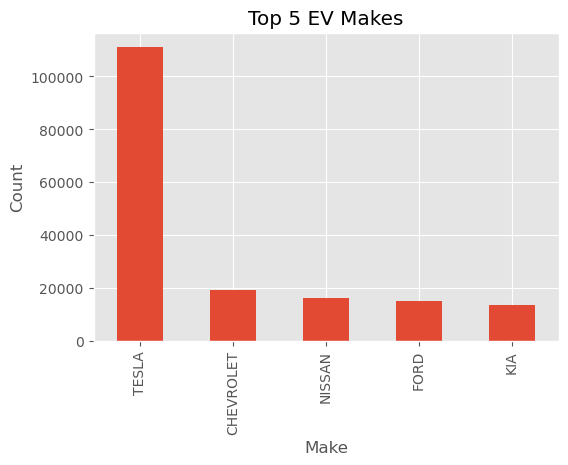

In [40]:
plt.style.use('ggplot')

# Bar chart: Top 5 EV makes
if 'Make' in dataset.columns:
    top_makes = dataset['Make'].value_counts().head(5)
    plt.figure(figsize=(6,4))
    top_makes.plot(kind='bar')
    plt.title("Top 5 EV Makes")
    plt.xlabel("Make")
    plt.ylabel("Count")
    plt.show()

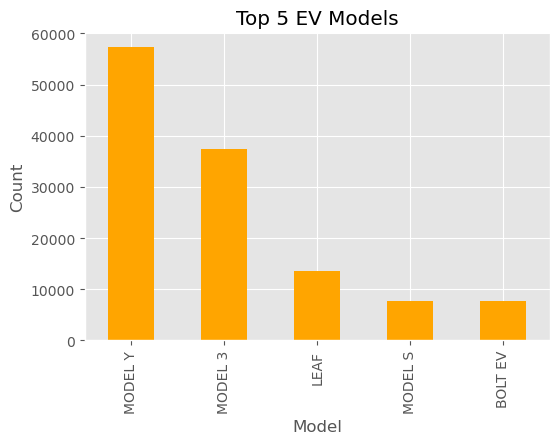

In [41]:
# Bar chart: Top 5 EV models
if 'Model' in dataset.columns:
    top_models = dataset['Model'].value_counts().head(5)
    plt.figure(figsize=(6,4))
    top_models.plot(kind='bar', color='orange')
    plt.title("Top 5 EV Models")
    plt.xlabel("Model")
    plt.ylabel("Count")
    plt.show()


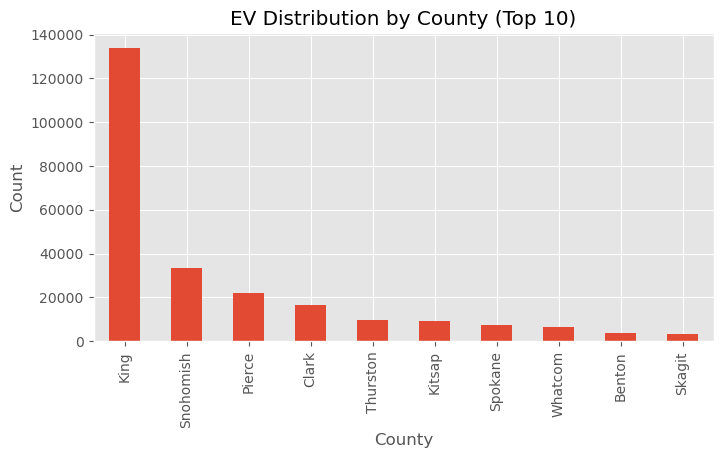

In [42]:
#  County distribution (simple bar)
if 'County' in dataset.columns:
    plt.figure(figsize=(8,4))
    dataset['County'].value_counts().head(10).plot(kind='bar')
    plt.title("EV Distribution by County (Top 10)")
    plt.xlabel("County")
    plt.ylabel("Count")
    plt.show()

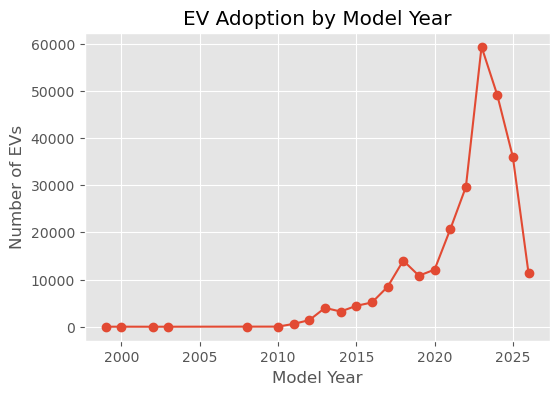

In [43]:
#  Line graph: EV adoption by model year
if 'Model Year' in dataset.columns:
    plt.figure(figsize=(6,4))
    model_year_counts.plot(kind='line', marker='o')
    plt.title("EV Adoption by Model Year")
    plt.xlabel("Model Year")
    plt.ylabel("Number of EVs")
    plt.show()

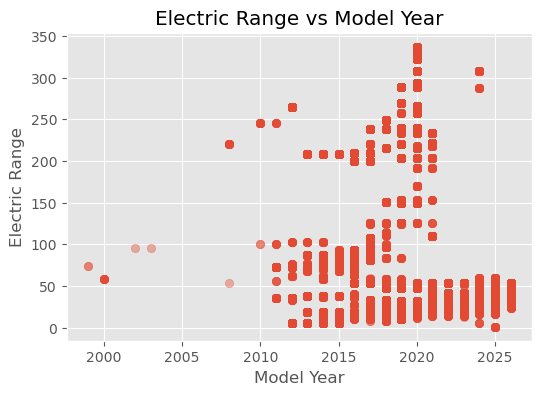

In [44]:
#  Scatter plot: Electric Range vs (no Base MSRP, so use Model Year)
if 'Electric Range' in dataset.columns and 'Model Year' in dataset.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(dataset['Model Year'], dataset['Electric Range'], alpha=0.4)
    plt.title("Electric Range vs Model Year")
    plt.xlabel("Model Year")
    plt.ylabel("Electric Range")
    plt.show()

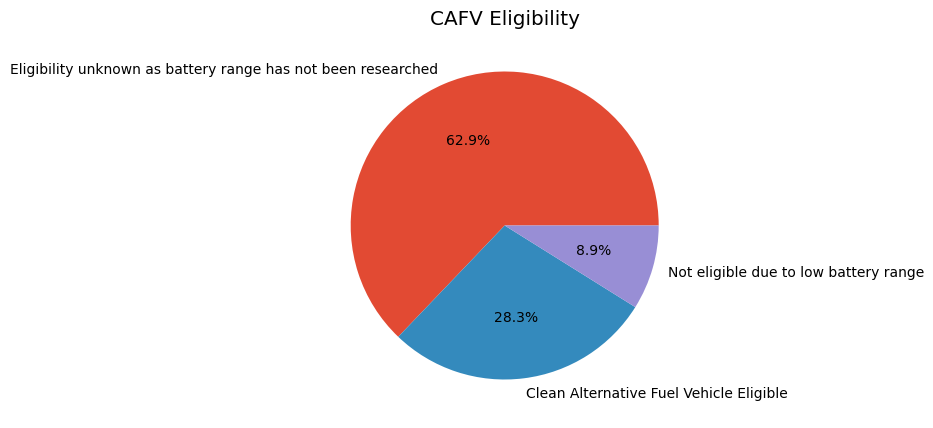

In [45]:
#  Pie chart: CAFV eligibility
if cafv_col in dataset.columns:
    plt.figure(figsize=(5,5))
    cafv_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title("CAFV Eligibility")
    plt.ylabel("")
    plt.show()

# LINEAR REGRESSION MODEL

In [93]:
# Work on a copy to avoid warnings
reg_data = dataset.copy()

# Keep only top 5 makes, others as 'OTHER'
top_makes = reg_data['Make'].value_counts().head(5).index
reg_data['Make_Simple'] = reg_data['Make'].apply(
    lambda x: x if x in top_makes else 'OTHER'
)

# Dummy variables for Make_Simple
make_dummies = pd.get_dummies(reg_data['Make_Simple'], prefix='Make')

# Feature matrix X and target y
X = pd.concat([reg_data[['Model Year']], make_dummies], axis=1)
y = reg_data['Electric Range']

print("Feature columns:\n", X.columns.tolist())
print("X shape:", X.shape, "y shape:", y.shape)

Feature columns:
 ['Model Year', 'Make_CHEVROLET', 'Make_FORD', 'Make_KIA', 'Make_NISSAN', 'Make_OTHER', 'Make_TESLA']
X shape: (270262, 7) y shape: (270262,)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

# Create and fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("\nR² score:", r2)
print("Intercept:", lr_model.intercept_)
print("\nCoefficients:")
for col, coef in zip(X.columns, lr_model.coef_):
    print(col, ":", coef)

Train shapes: (216209, 7) (216209,)
Test shapes: (54053, 7) (54053,)

R² score: 0.2787057637989948
Intercept: 18113.03916735047

Coefficients:
Model Year : -8.924878923951354
Make_CHEVROLET : 19.894190423824988
Make_FORD : -25.424547412325147
Make_KIA : 1.5143377911855886
Make_NISSAN : -11.35280080714975
Make_OTHER : -13.724816135479657
Make_TESLA : 29.093636139943627


In [95]:
# Build example row with same columns as X
example = pd.DataFrame({'Model Year': [2024]}, index=[0])

# Add all dummy columns with 0
for c in make_dummies.columns:
    example[c] = 0

# Set one make to 1 (first top make)
first_make_col = make_dummies.columns[0]   # e.g. 'Make_TESLA'
example[first_make_col] = 1

# Reorder columns to match X
example = example[X.columns]

print("\nExample row:")
print(example)

predicted_range = lr_model.predict(example)[0]
print("\nPredicted Electric Range for example EV:", predicted_range)


Example row:
   Model Year  Make_CHEVROLET  Make_FORD  Make_KIA  Make_NISSAN  Make_OTHER  \
0        2024               1          0         0            0           0   

   Make_TESLA  
0           0  

Predicted Electric Range for example EV: 68.97841569675438
